In [2]:
# libraries for load
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# missing data imputation
from feature_engine.imputation  import MeanMedianImputer, ArbitraryNumberImputer, CategoricalImputer
from sklearn.impute import SimpleImputer

# data prepocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# feature scaling
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer
)

# encoding
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

# metrics
from sklearn.metrics import roc_auc_score

# set random seed
np.random.seed(0)

# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/titanic.csv')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Data Exploration

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


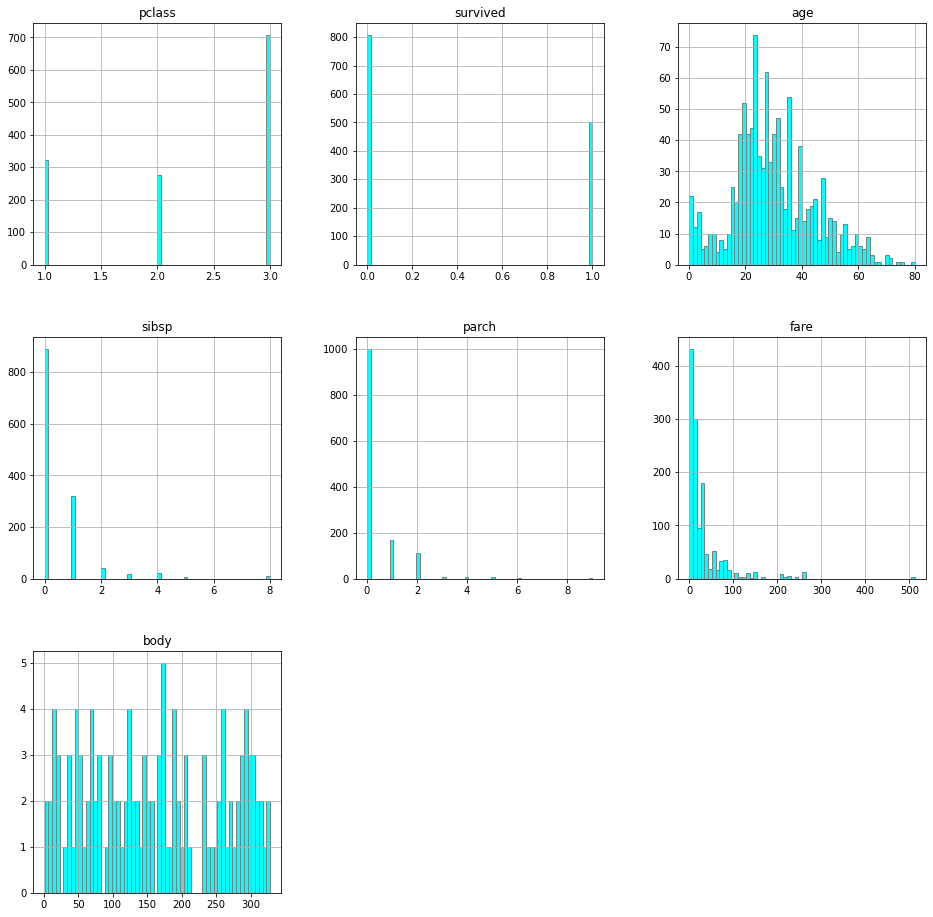

In [100]:
# numerical features distribution
fig_ = data.hist(figsize=(16, 16), bins=60, color="cyan",
                         edgecolor="gray", xlabelsize=10, ylabelsize=10)

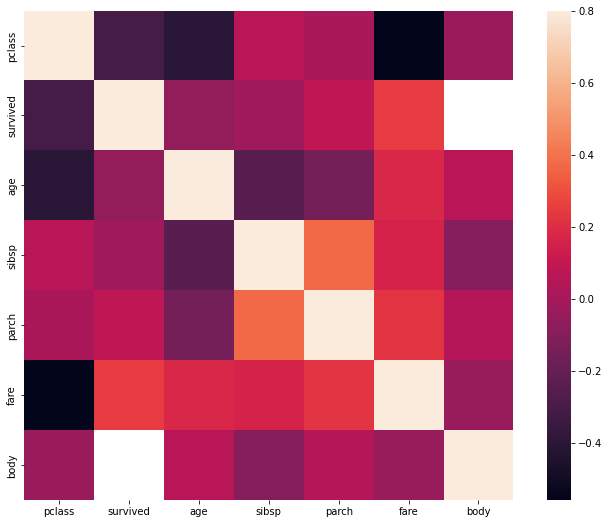

In [35]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig("corrmat.png")

Text(0.5, 1.0, 'Passenger Age Distribution')

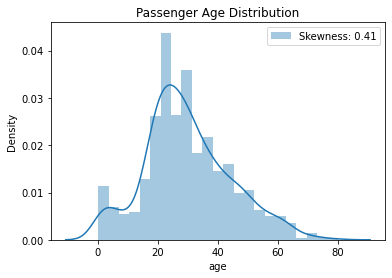

In [36]:
# check distribution of age variable

sns.distplot(data['age'], label = 'Skewness: %.2f'%(data['age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

Text(0.5, 1.0, 'Passenger Fare Distribution')

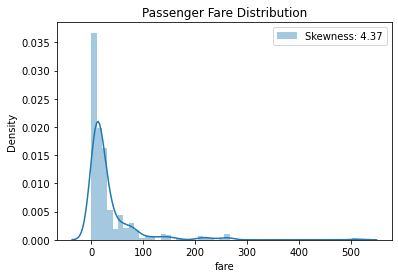

In [37]:
# check distribution of fare variable

sns.distplot(data['fare'], label = 'Skewness: %.2f'%(data['fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [38]:
survived_count = data['survived'].value_counts(dropna = False)
survived_count

0    809
1    500
Name: survived, dtype: int64

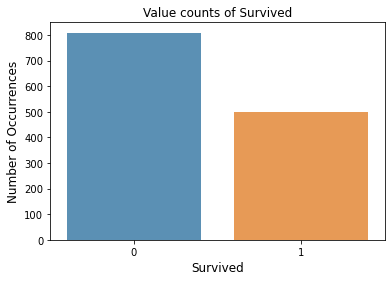

In [39]:
# check distribution of target variable

sns.barplot(survived_count.index, survived_count.values, alpha = 0.8)
plt.title('Value counts of Survived')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Survived', fontsize = 12)
plt.show()

## Feature Engineering

In [40]:
# remove useless features name, home.dest and body.
# remove boat feature. This variable has too much correlation with target variable.
data = data.drop(['name', 'home.dest', 'body', 'boat'], axis=1)
data.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,male,0.9167,1,2,113781,151.5500,C22,S
2,1,0,female,2.0000,1,2,113781,151.5500,C22,S
3,1,0,male,30.0000,1,2,113781,151.5500,C22,S
4,1,0,female,25.0000,1,2,113781,151.5500,C22,S


In [41]:
# transform cabin feature to categorical variable
cabin_only = data[["cabin"]].copy()
cabin_only["Deck"] = cabin_only["cabin"].str.slice(0,1)
data = data.assign(cabin = cabin_only["Deck"])
data.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,female,29.0000,0,0,24160,211.3375,B,S
1,1,1,male,0.9167,1,2,113781,151.5500,C,S
2,1,0,female,2.0000,1,2,113781,151.5500,C,S
3,1,0,male,30.0000,1,2,113781,151.5500,C,S
4,1,0,female,25.0000,1,2,113781,151.5500,C,S


In [101]:
data.ticket.unique()

array(['24160', '113781', '19952', '13502', '112050', '11769', 'PC 17609',
       'PC 17757', 'PC 17477', '19877', '27042', 'PC 17318', 'PC 17558',
       '11813', '13050', '11751', '111369', 'PC 17483', '13905', '11967',
       'PC 17760', '110564', '113784', '112277', '36928', '113783',
       '110489', 'PC 17608', '113505', '111427', '113054', 'PC 17591',
       '112379', 'PC 17610', '16966', '113050', '113798', 'PC 17476',
       'PC 17606', 'PC 17755', '695', '113059', '113760', '19924',
       '17770', 'W.E.P. 5734', '113806', '110152', 'PC 17594', '112051',
       '13508', '110465', '5727', 'PC 17756', '11770', '113791',
       'WE/P 5735', '112901', 'PC 17599', '113055', '113804',
       'F.C. 12750', '17474', '33638', 'PC 17761', '11755', 'PC 17485',
       'PC 17580', '11767', '36947', 'PC 17531', 'PC 17598', '17421',
       'PC 17474', '113051', '19950', '113778', 'PC 17611', '17765',
       '13568', '13567', '112058', '113803', '111320', '113503', '112378',
       'PC 17593

In [42]:
# transform ticket feature to numerical variable
data['ticket_num'] = data['ticket'].apply(lambda s: s.split()[-1])
data['ticket_num'] = pd.to_numeric(data['ticket_num'],
                                   errors = 'coerce',
                                   downcast = 'integer')

data['ticket_cat'] = data['ticket'].apply(lambda s: s.split()[0])
data['ticket_cat'] = np.where(data['ticket_cat'].str.isdigit(), np.nan, data['ticket_cat'])

data.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,ticket_num,ticket_cat
0,1,1,female,29.0000,0,0,24160,211.3375,B,S,24160.0,NaN
1,1,1,male,0.9167,1,2,113781,151.5500,C,S,113781.0,NaN
2,1,0,female,2.0000,1,2,113781,151.5500,C,S,113781.0,NaN
3,1,0,male,30.0000,1,2,113781,151.5500,C,S,113781.0,NaN
4,1,0,female,25.0000,1,2,113781,151.5500,C,S,113781.0,NaN


In [43]:
# drop useless ticket_cat and ticket columns
data = data.drop(['ticket_cat', 'ticket'], axis=1)

In [44]:
# count family members
data["FamilyMemberCount"] = data["sibsp"] + data["parch"] + 1

In [45]:
# create new variable to show is person alone or not
data["IsAlone"] = data["FamilyMemberCount"].apply(lambda x: 1 if x == 1 else 0)

In [46]:
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,ticket_num,FamilyMemberCount,IsAlone
0,1,1,female,29.0000,0,0,211.3375,B,S,24160.0,1,1
1,1,1,male,0.9167,1,2,151.5500,C,S,113781.0,4,0
2,1,0,female,2.0000,1,2,151.5500,C,S,113781.0,4,0
3,1,0,male,30.0000,1,2,151.5500,C,S,113781.0,4,0
4,1,0,female,25.0000,1,2,151.5500,C,S,113781.0,4,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pclass             1309 non-null   int64  
 1   survived           1309 non-null   int64  
 2   sex                1309 non-null   object 
 3   age                1046 non-null   float64
 4   sibsp              1309 non-null   int64  
 5   parch              1309 non-null   int64  
 6   fare               1308 non-null   float64
 7   cabin              295 non-null    object 
 8   embarked           1307 non-null   object 
 9   ticket_num         1305 non-null   float64
 10  FamilyMemberCount  1309 non-null   int64  
 11  IsAlone            1309 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 122.8+ KB


## Missing Data imputation

In [48]:
# separate into training and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['survived'], axis = 1),
                                                   data['survived'],
                                                   test_size=0.25,
                                                   random_state=0)
X_train.shape, X_test.shape

((981, 11), (328, 11))

In [49]:
X_train.pclass = X_train.pclass.astype('category')
X_train.sex = X_train.sex.astype('category')
X_train.cabin = X_train.cabin.astype('category')
#X_train.boat = X_train.boat.astype('category')
X_train.embarked = X_train.embarked.astype('category')
X_train.ticket_num = X_train.ticket_num.astype('category')

X_test.pclass = X_test.pclass.astype('category')
X_test.sex = X_test.sex.astype('category')
X_test.cabin = X_test.cabin.astype('category')
#X_test.boat = X_test.boat.astype('category')
X_test.embarked = X_test.embarked.astype('category')
X_test.ticket_num = X_test.ticket_num.astype('category')

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 747 to 684
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   pclass             981 non-null    category
 1   sex                981 non-null    category
 2   age                791 non-null    float64 
 3   sibsp              981 non-null    int64   
 4   parch              981 non-null    int64   
 5   fare               980 non-null    float64 
 6   cabin              231 non-null    category
 7   embarked           979 non-null    category
 8   ticket_num         978 non-null    category
 9   FamilyMemberCount  981 non-null    int64   
 10  IsAlone            981 non-null    int64   
dtypes: category(5), float64(2), int64(4)
memory usage: 82.0 KB


In [51]:
# check missing data

X_train.isnull().sum().sort_values(ascending = False)

cabin                750
age                  190
ticket_num             3
embarked               2
fare                   1
pclass                 0
sex                    0
sibsp                  0
parch                  0
FamilyMemberCount      0
IsAlone                0
dtype: int64

In [52]:
# function to impute cabin variable
def cabin_imputer(data):
    columns_names = [c for c in data.columns]
    first_class = data.loc[data.pclass == 1]
    second_class = data.loc[data.pclass == 2]
    third_class = data.loc[data.pclass == 3]
    imputer = SimpleImputer(strategy = 'most_frequent')
    imputer.fit(first_class['cabin'].values.reshape(-1, 1))
    imputer.fit(second_class['cabin'].values.reshape(-1, 1))
    imputer.fit(third_class['cabin'].values.reshape(-1, 1))
    first_class['cabin'] = imputer.transform(first_class['cabin'].values.reshape(-1, 1))
    second_class['cabin'] = imputer.transform(second_class['cabin'].values.reshape(-1, 1))
    third_class['cabin'] = imputer.transform(third_class['cabin'].values.reshape(-1, 1))
    data = pd.concat([first_class, second_class, third_class])
    return data

In [53]:
X_train.isnull().sum().sort_values(ascending = False)

cabin                750
age                  190
ticket_num             3
embarked               2
fare                   1
pclass                 0
sex                    0
sibsp                  0
parch                  0
FamilyMemberCount      0
IsAlone                0
dtype: int64

In [54]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,ticket_num,FamilyMemberCount,IsAlone
747,3,male,0.3333,0,2,14.4000,NaN,S,347080.0,3,0
565,2,male,25.0000,0,0,13.0000,NaN,S,29178.0,1,1
82,1,female,36.0000,0,2,71.0000,B,S,5735.0,3,0
567,2,male,25.0000,0,0,10.5000,NaN,S,13540.0,1,1
863,3,male,28.0000,0,0,7.8958,NaN,S,349243.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,2315.0,4,0
835,3,male,NaN,0,0,8.0500,NaN,S,376563.0,1,1
1216,3,female,NaN,0,0,7.7333,NaN,Q,335432.0,1,1
559,2,female,20.0000,0,0,36.7500,NaN,S,33112.0,1,1


In [55]:
# find categorical features
categorical_features = [var for var in X_train.columns if X_train[var].dtype == 'category' ]

# find numerical features
numerical_features = [var for var in X_train.columns if X_train[var].dtype != 'category' and var != 'survived']

print("Numerical vars: {}".format(len(numerical_features)))
print("Categorical vars: {}".format(len(categorical_features)))

Numerical vars: 6
Categorical vars: 5


In [56]:
final_cols = X_train.columns

In [57]:
# pipeline for imputation
impute_pipe = Pipeline([
    ('mean_imputer', MeanMedianImputer(imputation_method = 'mean', variables = ['age', 'fare'])),
    ('most_freq_imputer', CategoricalImputer(imputation_method = 'frequent', variables = ['embarked', 'ticket_num']))
])

In [58]:
X_train = cabin_imputer(X_train).reindex(X_train.index)
X_test = cabin_imputer(X_test).reindex(X_test.index)

In [59]:
X_train = impute_pipe.fit_transform(X_train)
X_test = impute_pipe.fit_transform(X_test)

In [60]:
X_train.isnull().mean()

pclass               0.0
sex                  0.0
age                  0.0
sibsp                0.0
parch                0.0
fare                 0.0
cabin                0.0
embarked             0.0
ticket_num           0.0
FamilyMemberCount    0.0
IsAlone              0.0
dtype: float64

## Model Training

In [61]:
# function with column transformer
def preprocessor_pipe(scaler):
    pipe = Pipeline([
        ('rare_enc', RareLabelEncoder(tol = 0.05, n_categories=3)),
        ('ohe', OrdinalEncoder(encoding_method = 'ordered')),
        ('scaler', scaler)
    ])
    
    main_preprocessor = ColumnTransformer([
        ('pipe', pipe , final_cols)
    ])
    return main_preprocessor

# function with main pipeline
def clf_pipe(clf_model, main_preprocessor):
    clf = Pipeline([('preprocessor', main_preprocessor),
                    ('clf', clf_model)])
    return clf

In [62]:
# function to show model evaluation results
def score_func(grid_search_model, X_train, y_train, X_test, y_test):
    train_score = grid_search_model.score(X_train, y_train)
    test_score = grid_search_model.score(X_test, y_test)
    print("train roc_auc score: {0:.2g}".format(train_score))
    print("test roc_auc score: {0:.2g}".format(test_score))

### KNN

In [63]:
# create model wth pipeline for training
model_knn = clf_pipe(KNeighborsClassifier(weights = 'uniform',
                                    algorithm = 'auto',
                                    n_neighbors = 5,
                                    leaf_size = 30), 
               preprocessor_pipe(StandardScaler()))

In [64]:
param_grid = {
    'preprocessor__pipe__rare_enc__tol': [0.03, 0.04, 0.05],
    'preprocessor__pipe__rare_enc__n_categories': [2, 3, 4, 5],
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__algorithm': ['ball_tree', 'kd_tree', 'chebyshev', 'brute', 'auto'],
    'clf__leaf_size': [35, 50, 65]
}

grid_search_KNN = GridSearchCV(model_knn, param_grid, cv = 5, n_jobs = -1, scoring = 'roc_auc')

In [65]:
%%timeit -r 1 -n 1
grid_search_KNN.fit(X_train, y_train)

15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [66]:
score_func(grid_search_KNN, X_train, y_train, X_test, y_test)
# Standard Scaler - 0.82
# Robust Scaler - 0.8
# MinMaxScaler - 0.8

train roc_auc score: 0.91
test roc_auc score: 0.82


In [67]:
grid_search_KNN.best_params_

{'clf__algorithm': 'brute',
 'clf__leaf_size': 35,
 'clf__n_neighbors': 9,
 'preprocessor__pipe__rare_enc__n_categories': 2,
 'preprocessor__pipe__rare_enc__tol': 0.04}

### Gradient Boosting

In [68]:
model_gbc = clf_pipe(GradientBoostingClassifier(learning_rate = 0.1,
                                                criterion = 'friedman_mse',
                                                n_estimators = 100),
               preprocessor_pipe(StandardScaler()))

In [69]:
param_grid = {
    'preprocessor__pipe__rare_enc__tol': [0.03, 0.04, 0.05],
    'preprocessor__pipe__rare_enc__n_categories': [2, 3, 4, 5],
    'clf__learning_rate': [0.1, 0.3, 0.5],
    'clf__criterion': ['friedman_mse', 'squared_error', 'mse'],
    'clf__n_estimators': [100, 150, 200]
}

grid_search_GBC = GridSearchCV(model_gbc, param_grid, cv = 5, n_jobs = -1, scoring = 'roc_auc')

In [70]:
%%timeit -r 1 -n 1
grid_search_GBC.fit(X_train, y_train)

22.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
score_func(grid_search_GBC, X_train, y_train, X_test, y_test)
# Standard Scaler - 0.85
# Robust Scaler - 0.85
# MinMaxScaler - 0.85

train roc_auc score: 0.94
test roc_auc score: 0.85


In [72]:
grid_search_GBC.best_params_

{'clf__criterion': 'squared_error',
 'clf__learning_rate': 0.1,
 'clf__n_estimators': 100,
 'preprocessor__pipe__rare_enc__n_categories': 5,
 'preprocessor__pipe__rare_enc__tol': 0.03}

### Logistic Regression

In [73]:
model_lr = clf_pipe(LogisticRegression(solver = 'lbfgs',
                                       penalty = 'l2',
                                       dual = False,
                                       max_iter = 300
                                      ),
               preprocessor_pipe(RobustScaler()))

In [74]:
param_grid = {'preprocessor__pipe__rare_enc__tol': [0.03, 0.04, 0.05],
              'preprocessor__pipe__rare_enc__n_categories': [2, 3, 4, 5],
              'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'clf__penalty': ['l1', 'l2', 'none', 'elasticnet'],
              'clf__dual': [True, False]}

grid_search_lr = GridSearchCV(model_lr, param_grid, cv = 5, n_jobs = -1, scoring = 'roc_auc')

In [75]:
%%timeit -r 1 -n 1
grid_search_lr.fit(X_train, y_train)

7.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [76]:
score_func(grid_search_lr, X_train, y_train, X_test, y_test)
# Standard Scaler - 0.85
# Robust Scaler - 0.85
# MinMaxScaler - 0.85

train roc_auc score: 0.85
test roc_auc score: 0.85


In [77]:
grid_search_lr.best_params_

{'clf__dual': True,
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear',
 'preprocessor__pipe__rare_enc__n_categories': 2,
 'preprocessor__pipe__rare_enc__tol': 0.04}

### Random Forest

In [78]:
model_rf = clf_pipe(RandomForestClassifier(criterion = 'gini',
                                           min_samples_split = 2,
                                           min_samples_leaf = 1,
                                           n_estimators = 100,
                                           random_state = 33),
               preprocessor_pipe(MinMaxScaler()))

In [79]:
param_grid = {'preprocessor__pipe__rare_enc__tol': [0.03, 0.04, 0.05],
              'preprocessor__pipe__rare_enc__n_categories': [2, 3, 4, 5],
              'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__min_samples_split': [2, 3, 4],
              'clf__min_samples_leaf': [1, 2, 3],
              'clf__n_estimators': [100, 200, 300]
             }

grid_search_rf = GridSearchCV(model_rf, param_grid, cv = 5, n_jobs = -1, scoring = 'roc_auc')

In [80]:
%%timeit -r 1 -n 1
grid_search_rf.fit(X_train, y_train)

1min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [81]:
score_func(grid_search_rf, X_train, y_train, X_test, y_test)
# Standard Scaler - 0.85
# Robust Scaler - 0.85
# MinMaxScaler - 0.85

train roc_auc score: 0.96
test roc_auc score: 0.85


In [82]:
grid_search_rf.best_params_

{'clf__criterion': 'entropy',
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 300,
 'preprocessor__pipe__rare_enc__n_categories': 2,
 'preprocessor__pipe__rare_enc__tol': 0.04}

### SVM

In [83]:
model_svc = clf_pipe(SVC(kernel = 'rbf',
                         C = 1.0,
                         degree = 3,
                         gamma = 'scale',
                         random_state = 33),
               preprocessor_pipe(RobustScaler()))

In [84]:
param_grid = {'preprocessor__pipe__rare_enc__tol': [0.03, 0.04, 0.05],
              'preprocessor__pipe__rare_enc__n_categories': [2, 3, 4, 5],
              'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'clf__C': [0.9, 1.0, 1.1, 1.2],
              'clf__degree': [2, 3, 4],
              'clf__gamma': ['scale', 'auto']
             }

grid_search_svc = GridSearchCV(model_svc, param_grid, cv = 5, n_jobs = -1, scoring = 'roc_auc')

In [85]:
%%timeit -r 1 -n 1
grid_search_svc.fit(X_train, y_train)

35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [86]:
score_func(grid_search_svc, X_train, y_train, X_test, y_test)
# Standard Scaler - 0.82
# Robust Scaler - 0.83
# MinMaxScaler - 0.8

train roc_auc score: 0.86
test roc_auc score: 0.83


In [87]:
grid_search_svc.best_params_

{'clf__C': 0.9,
 'clf__degree': 2,
 'clf__gamma': 'scale',
 'clf__kernel': 'poly',
 'preprocessor__pipe__rare_enc__n_categories': 2,
 'preprocessor__pipe__rare_enc__tol': 0.05}

## Results

In [88]:
# Gradient Boosting Classifier - best performance
score_func(grid_search_GBC, X_train, y_train, X_test, y_test)

train roc_auc score: 0.94
test roc_auc score: 0.85


In [89]:
grid_search_GBC.best_params_

{'clf__criterion': 'squared_error',
 'clf__learning_rate': 0.1,
 'clf__n_estimators': 100,
 'preprocessor__pipe__rare_enc__n_categories': 5,
 'preprocessor__pipe__rare_enc__tol': 0.03}

<AxesSubplot:>

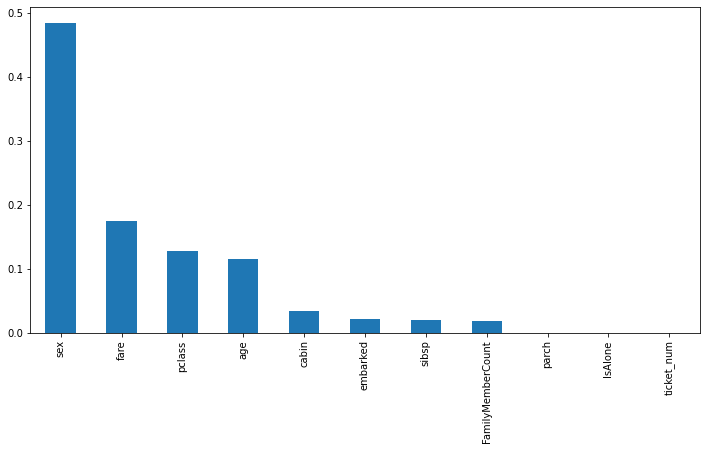

In [90]:
# the most important features

importance = pd.Series(grid_search_GBC.best_estimator_.named_steps['clf'].feature_importances_)
importance.index = final_cols
importance.sort_values(inplace = True, ascending = False)
importance.plot.bar(figsize = (12, 6))

As you can see Gradient Boosting Classifier shows best performance, but there is an overfit as well.